In [1]:
import requests
import bs4
import time
import pandas as pd
import seaborn as sns
%matplotlib inline

/home/sayamada/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/home/sayamada/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [62]:
# イベント一覧の取得
# connpas のAPIをつかってJSONで取得
resp = requests.get("http://connpass.com/api/v1/event/?series_id=1319")
data = resp.json()

In [63]:
# APIの結果を処理して、eventの一覧等を取得
event_dict_list = []
for i,x in enumerate(sorted(data["events"],lambda x,y: int(y["event_id"])-int(x["event_id"]))):
    tmp_dict = {
        "title": x["title"],
        "event_id":x["event_id"],
        "event_url":x["event_url"],
        "limit":x["limit"],
        "accepted":x["accepted"]
    }
    event_dict_list.append(tmp_dict)
    
event_dict_list.reverse()
event_df = pd.DataFrame(event_dict_list[:-1])
event_df

,accepted,event_id,event_url,limit,title
0,65,20092,http://startpython.connpass.com/event/20092/,85,業務のためのPython勉強会#5
1,81,21490,http://startpython.connpass.com/event/21490/,90,みんなのPython勉強会#6
2,76,22661,http://startpython.connpass.com/event/22661/,90,みんなのPython勉強会#7
3,80,24092,http://startpython.connpass.com/event/24092/,90,みんなのPython勉強会#8
4,77,25235,http://startpython.connpass.com/event/25235/,90,みんなのPython勉強会#9
5,126,25269,http://startpython.connpass.com/event/25269/,152,みんなのPython勉強会#10
6,116,28359,http://startpython.connpass.com/event/28359/,130,みんなのPython勉強会#11
7,115,28360,http://startpython.connpass.com/event/28360/,130,みんなのPython勉強会#12
8,144,29936,http://startpython.connpass.com/event/29936/,150,みんなのPython勉強会#13


In [4]:
# 参加者の情報を取得
# 参加者の一覧を取得するAPIはないので、URLを組み立てて実際にスクレイピングする
soup_list = []
for url in event_df["event_url"]:
    time.sleep(1)
    print url+"participation/#participants"
    # html5libでパースしないとHTMLが空になるケースがあった。おそらくpython2.7でやったから？
    soup_list.append(bs4.BeautifulSoup(requests.get(url+"participation/#participants").content, "html5lib"))

http://startpython.connpass.com/event/20092/participation/#participants
http://startpython.connpass.com/event/21490/participation/#participants
http://startpython.connpass.com/event/22661/participation/#participants
http://startpython.connpass.com/event/24092/participation/#participants
http://startpython.connpass.com/event/25235/participation/#participants
http://startpython.connpass.com/event/25269/participation/#participants
http://startpython.connpass.com/event/28359/participation/#participants
http://startpython.connpass.com/event/28360/participation/#participants
http://startpython.connpass.com/event/29936/participation/#participants


In [5]:
# ユーザ名と個人ページURLのマッピングデータ
user_page_dict = {}

In [6]:
# 出席一覧の取得
# 参加者と参加者ページのマッピングも作成
attend_list_list = []
for soup in soup_list:
    # HTMLを目でみてこのクラスがあるTABLEタグと判断
    table_data = soup.find_all(class_="participation_table_area")
    tmp_attend = []
    for table in table_data:
        table.findAll(class_="display_name")
        for part in table.find_all(class_="display_name"):
            if part.find("a"):
                tmp_attend.append(part.find("a").text)
                user_page_dict[part.find("a").text] = part.find("a").get("href")
    attend_list_list.append(tmp_attend)
    

In [7]:
# キャンセル一覧の取得
# 参加者と参加者ページのマッピングも作成
cancelled_list_list = []
for soup in soup_list:
    # HTMLを目でみてこのクラスがあるTABLEタグと判断
    table_data = soup.find_all(class_="cancelled_table_area")
    tmp_attend = []
    for table in table_data:
        table.findAll(class_="display_name")
        for part in table.find_all(class_="display_name"):
            if part.find("a"):
                tmp_attend.append(part.find("a").text)
                user_page_dict[part.find("a").text] = part.find("a").get("href")
    cancelled_list_list.append(tmp_attend)

,NO,attend,cancel,total,limit
0,5,65,33,98,85
1,6,80,50,130,90
2,7,76,44,120,90
3,8,80,66,146,90
4,9,74,59,133,90
5,10,126,72,198,152
6,11,116,81,197,130
7,12,115,72,187,130
8,13,143,64,207,150


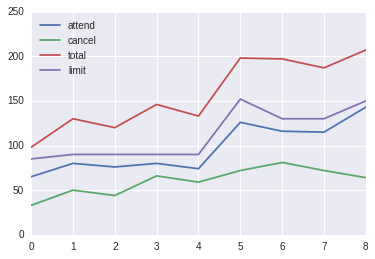

In [8]:
# 出席、キャンセル、申し込み合計
tmp_list = []
for i,(attend,cancel) in enumerate(zip(attend_list_list,cancelled_list_list)):
    tmp_list.append([i+5, len(attend), len(cancel), len(attend + cancel), ])

total_df = pd.DataFrame(tmp_list, columns=["NO","attend","cancel", "total"])
total_df["limit"] = event_df["limit"]
total_df[["attend","cancel", "total","limit"]].plot()
total_df

In [10]:
# 個人ページから、イベントへの参加数・管理数・ブックマーク数を取得する
# !! すごい負荷かかる !!
def get_user_info(user_name):
    page_url = user_page_dict[user_name]
    resp = requests.get(page_url)
    soup = bs4.BeautifulSoup(resp.content)
    # 数字が並んでいるところのcssのclassを頼りに取得
    num_data = soup.find(class_="square_tab").find_all(class_="num")
    return {
        "attend": num_data[0].text,
        "manage": num_data[1].text,
        "bookmark": num_data[2].text
    }

# ユーザの参加詳細をまとめる
user_info = {}
for username in user_page_dict:
    # if you want, delete #
    #user_info[username]= get_user_info(username)


In [64]:
print user_info[u"やまだ"]

{'bookmark': u'1', 'manage': u'0', 'attend': u'22'}


In [12]:
# Pandasだけで綺麗にデータを整えられないPandas弱者
# なので、DBに表として一回しまってしまうDBAソリューション
import sqlite3 as sqlite
conn = sqlite.connect("stapy.db")
cur = conn.cursor()
cur.execute("""
create table IF NOT EXISTS tmp_stat(username, a5,c5,a6,c6,a7,c7,a8,c8,a9,c9,a10,c10,a11,c11,a12,c12,a13,c13,attend,manage,bookmark);
"""
)

for x in user_page_dict:
    cur.execute(u"insert into tmp_stat values('{}',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)".format(x))

## 参加登録
for i,x in enumerate(attend_list_list):
    #print i,x 
    for username in x:
        cur.execute(u"update tmp_stat set a{} = 1 where username='{}'".format(i+5, username) )

## 欠席登録
for i,x in enumerate(cancelled_list_list):
    #print i,x 
    for username in x:
        cur.execute(u"update tmp_stat set c{} = 1 where username='{}'".format(i+5, username) )

## 参加数処理
for username,val in user_info.items():
    cur.execute(u"update tmp_stat set attend={}, manage={}, bookmark={} where username='{}'".format(
            val["attend"], val["manage"], val["bookmark"],  username
        )
    )
        
conn.commit()
conn.close()

## ここから統計

In [52]:
import sqlite3 as sqlite
# SQLiteから再取得
conn = sqlite.connect("stapy.db")
cur = conn.cursor()
# !!!!
# データ避けてるのでコピーしておいたtmp_stat2をFROM句にしている。読み込んだデータを使うならtmp_statに書き換える
# !!!
last_df = pd.DataFrame(cur.execute(u"select * from tmp_stat2").fetchall() ,columns=[
        "username",
        "a5",
        "c5",
        "a6",
        "c6",
        "a7",
        "c7",
        "a8",
        "c8",
        "a9",
        "c9",
        "a10",
        "c10",
        "a11",
        "c11",
        "a12",
        "c12",
        "a13",
        "c13",
        "attend",
        "manage",
        "bookmark",])
conn.close()
# スライド投影時を踏まえ、user名の上書き
last_df["username"] = ["user_"+ str(x) for x in range(last_df["username"].count())]

In [53]:
# 合計参加・キャンセル数の追加
last_df["total_cancel"] = (last_df["c6"] + last_df["c7"] + last_df["c8"] + last_df["c9"] + last_df["c10"] + last_df["c11"] +last_df["c12"] + last_df["c13"])
last_df["total_attend"] = (last_df["a6"] + last_df["a7"] + last_df["a8"] + last_df["a9"] + last_df["a10"] + last_df["a11"] +last_df["a12"] + last_df["a13"])

last_df

,username,a5,c5,a6,c6,a7,c7,a8,c8,a9,...,c11,a12,c12,a13,c13,attend,manage,bookmark,total_cancel,total_attend
0,user_0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,27,0,0,0,0
1,user_1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,2,0,0,0,2
2,user_2,0,1,1,0,0,1,0,0,1,...,0,0,1,0,0,13,0,0,2,3
3,user_3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,15,0,0,2,0
4,user_4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,3,0,0,0,1
5,user_5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6,user_6,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,3,0,0,0,2
7,user_7,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,3,0,0,1,0
8,user_8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
9,user_9,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [54]:
last_df[["username","total_attend","total_cancel"]].sort_values(by="total_cancel")

,username,total_attend,total_cancel
0,user_0,0,0
393,user_393,2,0
392,user_392,0,0
391,user_391,1,0
382,user_382,1,0
381,user_381,0,0
377,user_377,1,0
375,user_375,2,0
373,user_373,2,0
372,user_372,1,0


In [55]:
last_df.describe()

,a5,c5,a6,c6,a7,c7,a8,c8,a9,c9,...,c11,a12,c12,a13,c13,attend,manage,bookmark,total_cancel,total_attend
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,...,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000
mean,0.118168,0.073855,0.096012,0.048744,0.112260,0.064993,0.118168,0.097489,0.109306,0.087149,...,0.119645,0.169867,0.106352,0.186115,0.026588,18.163959,0.800591,0.131462,0.657312,1.149188
std,0.323046,0.261729,0.294825,0.215493,0.315919,0.246695,0.323046,0.296842,0.312253,0.282262,...,0.324786,0.375794,0.308515,0.389487,0.160995,54.224288,11.352090,0.873085,0.879161,1.409988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,906.000000,288.000000,15.000000,6.000000,8.000000


attendとかmanageみるとトンでるような

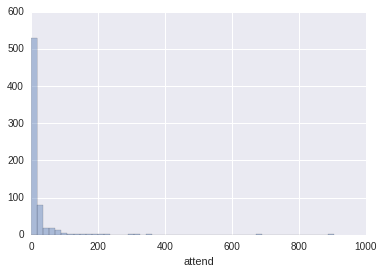

In [56]:
sns.distplot(last_df["attend"], kde=False, rug=False)

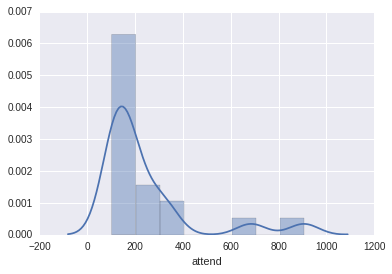

In [65]:
sns.distplot(last_df[last_df["attend"] > 100]["attend"])

In [59]:
# イベント参加数100以上を除いて考える
target_df = last_df[last_df["attend"] < 100]
target_df.describe()

,a5,c5,a6,c6,a7,c7,a8,c8,a9,c9,...,c11,a12,c12,a13,c13,attend,manage,bookmark,total_cancel,total_attend
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,...,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000
mean,0.118541,0.074468,0.092705,0.047112,0.110942,0.063830,0.117021,0.095745,0.109422,0.083587,...,0.115502,0.165653,0.107903,0.185410,0.027356,11.673252,0.376900,0.107903,0.641337,1.139818
std,0.323494,0.262731,0.290239,0.212041,0.314300,0.244635,0.321690,0.294465,0.312406,0.276977,...,0.319869,0.372052,0.310494,0.388926,0.163242,17.417723,2.610285,0.718678,0.863037,1.399683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,95.000000,40.000000,15.000000,6.000000,8.000000


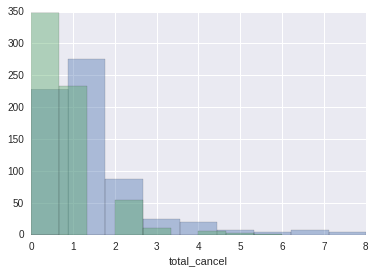

In [60]:
# 参加数
sns.distplot(target_df["total_attend"], kde=False, rug=False, bins=9)
# 欠席数
sns.distplot(target_df["total_cancel"], kde=False, rug=False, bins=9)

677 612


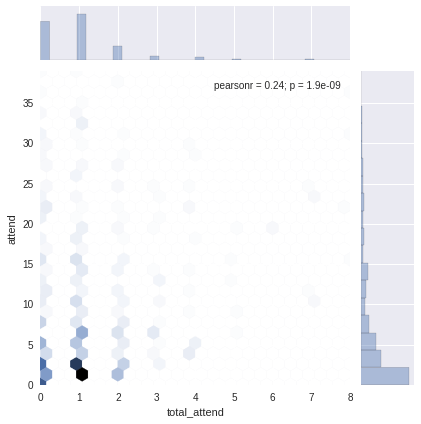

In [33]:
# 勉強会への参加数とStapyへの参加数に相関あるかとおもったがそんなことはなかった
sub_df = last_df[last_df["attend"] < 40]
print len(last_df), len(sub_df)
sns.jointplot(data=sub_df, x="total_attend", y="attend", kind="hex")

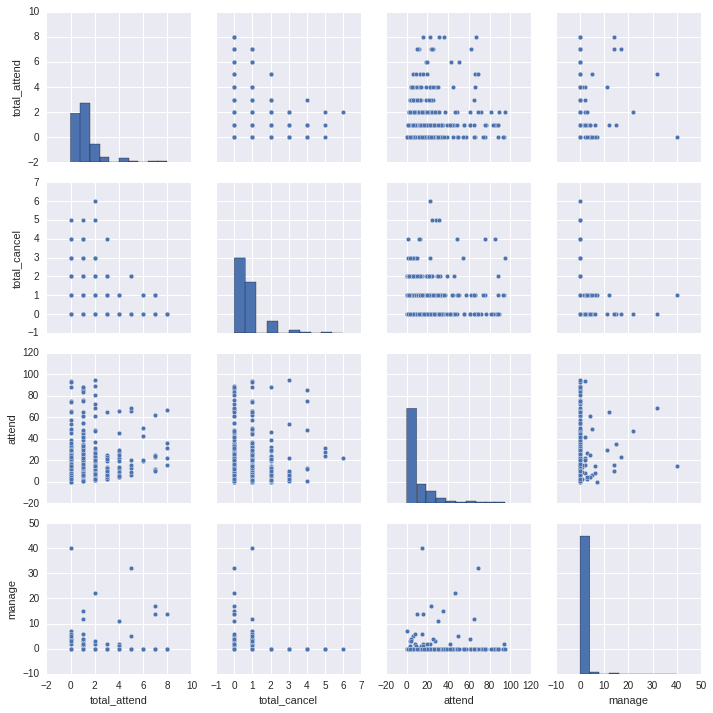

In [66]:
# 手当たりしたい掛けてみたが特に見つからなかった
sns.pairplot(target_df[["total_attend","total_cancel","attend","manage"]])
sns.plt.show()

* 3回参加するかが節目？
    - 商売だったら3回参加でキャンペーンしたくなる
* 他の相関はいまいち変わらず
* 統計難しい